In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [7]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 1000


In [8]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  147

X_mon1_train :  (999, 147)
y_mon1_train :  (999,)
X_mon1_val :  (334, 147)
y_mon1_val :  (334,)
X_mon1_test :  (667, 147)
y_mon1_test :  (667,)



In [9]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (999, 2298)
y_mon2_train :  (999,)
X_mon2_val :  (334, 2298)
y_mon2_val :  (334,)
X_mon2_test :  (667, 2298)
y_mon2_test :  (667,)



In [10]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot_img/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot_img/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
#X_mon3 = scaler.fit_transform(X_mon3)
X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (999, 128, 128, 1)
y_mon3_train :  (999,)
X_mon3_val :  (334, 128, 128, 1)
y_mon3_val :  (334,)
X_mon3_test :  (667, 128, 128, 1)
y_mon3_test :  (667,)



In [11]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top_img/ev_1'] )
hits_top_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B,hits_top_S])
# normalize
#X_mon4 = scaler.fit_transform(X_mon4)
X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (999, 128, 128, 1)
y_mon4_train :  (999,)
X_mon4_val :  (334, 128, 128, 1)
y_mon4_val :  (334,)
X_mon4_test :  (667, 128, 128, 1)
y_mon4_test :  (667,)



In [12]:
# close the h5 files
f_B.close()
f_S.close()

##### Load the compressed features

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


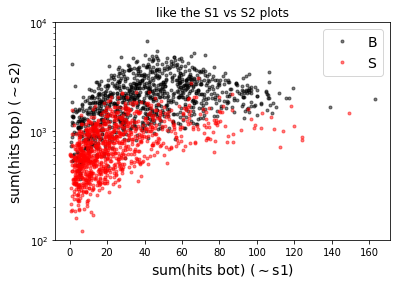

In [17]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# plot to check

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel(r'sum(hits bot) ($\sim$s1)',fontsize=14)
plt.ylabel(r'sum(hits top) ($\sim$s2)',fontsize=14)
plt.title('like the S1 vs S2 plots')
plt.legend(fontsize=14)
plt.show()

B_pbot.shape:  (1000,)
B_ptop.shape:  (1000,)
B_ppeakS1.shape : (1000, 8)
B_ppeakS2.shape:  (1000, 8)
S_pbot.shape:  (1000,)
S_ptop.shape:  (1000,)
S_ppeakS1.shape : (1000, 8)
S_ppeakS2.shape:  (1000, 8)
B_pdiffT.shape:  (1000,)
S_pdiffT.shape:  (1000,)


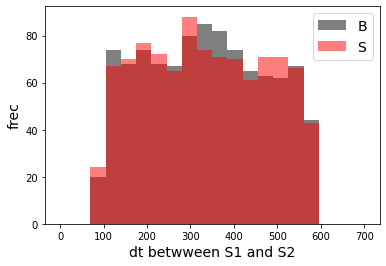

In [18]:
# to have the same number of background and signal events

B_pbot = B_pbot[:num_data]
B_ptop = B_ptop[:num_data]
B_ppeakS1 = B_ppeakS1[:num_data]
B_ppeakS2 = B_ppeakS2[:num_data]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [19]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (1000,)
B_ptop.shape:  (1000,)
B_ppeakS1.shape : (1000, 7)
B_ppeakS2.shape:  (1000, 7)
S_pbot.shape:  (1000,)
S_ptop.shape:  (1000,)
S_ppeakS1.shape : (1000, 7)
S_ppeakS2.shape:  (1000, 7)


In [20]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (1000, 17)
X_mon_S.shape:  (1000, 17)

X_mon5.shape:  (2000, 17)

X_mon5_train :  (999, 17)
y_mon5_train :  (999,)
X_mon5_val :  (334, 17)
y_mon5_val :  (334,)
X_mon5_test :  (667, 17)
y_mon5_test :  (667,)



In [21]:
X_mon1_val_SM = []
X_mon1_val_NP = []

for i in range(len(y_mon1_val)):
    if y_mon1_val[i] == 0:
        X_mon1_val_SM.append( X_mon1_val[i].tolist() )
    else:
        X_mon1_val_NP.append( X_mon1_val[i].tolist() )

        
X_mon2_val_SM = []
X_mon2_val_NP = []

for i in range(len(y_mon2_val)):
    if y_mon2_val[i] == 0:
        X_mon2_val_SM.append( X_mon2_val[i].tolist() )
    else:
        X_mon2_val_NP.append( X_mon2_val[i].tolist() )  
        
        
X_mon3_val_SM = []
X_mon3_val_NP = []

for i in range(len(y_mon3_val)):
    if y_mon3_val[i] == 0:
        X_mon3_val_SM.append( X_mon3_val[i].tolist() )
    else:
        X_mon3_val_NP.append( X_mon3_val[i].tolist() )

        
X_mon4_val_SM = []
X_mon4_val_NP = []

for i in range(len(y_mon4_val)):
    if y_mon4_val[i] == 0:
        X_mon4_val_SM.append( X_mon4_val[i].tolist() )
    else:
        X_mon4_val_NP.append( X_mon4_val[i].tolist() )  
        
         
X_mon5_val_SM = []
X_mon5_val_NP = []

for i in range(len(y_mon5_val)):
    if y_mon5_val[i] == 0:
        X_mon5_val_SM.append( X_mon5_val[i].tolist() )
    else:
        X_mon5_val_NP.append( X_mon5_val[i].tolist() )  

In [22]:
len(X_mon3_val_SM[0])

128

In [23]:
X_mon1_val_SM = np.asarray(X_mon1_val_SM)
X_mon2_val_SM = np.asarray(X_mon2_val_SM)
X_mon3_val_SM = np.asarray(X_mon3_val_SM)
X_mon4_val_SM = np.asarray(X_mon4_val_SM)
X_mon5_val_SM = np.asarray(X_mon5_val_SM)

In [24]:
X_mon1_val_NP = np.asarray(X_mon1_val_NP)
X_mon2_val_NP = np.asarray(X_mon2_val_NP)
X_mon3_val_NP = np.asarray(X_mon3_val_NP)
X_mon4_val_NP = np.asarray(X_mon4_val_NP)
X_mon5_val_NP = np.asarray(X_mon5_val_NP)

### CLASSIFIER

In [25]:
from keras.layers import concatenate
from tensorflow.keras.models import Model

#### 1 conv layer per block (final dense 32-16-1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 8,631,889
Trainable params: 8,631,889
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
8/8 [==============================] - 4s 462ms/step - loss: 6.9976 - accuracy: 0.6116 - val_loss: 1.1004 - val_accuracy: 0.8293
Epoch 2/1500
8/8 [==============================] - 3s 435ms/step - loss: 1.3800 - accuracy: 0.8178 - val_loss: 0.6533 - val_accuracy: 0.8593
Epoch 3/1500
8/8 [==============================] - 3s 439ms/step - loss: 0.8974 - accuracy: 0.7838 - val_loss: 0.9677 - val_accuracy: 0.6766
Epoch 4/1500
8/8 [==============================] - 3s 436ms/step - loss: 0.8029 - accuracy: 0.7798 - val_loss: 0.8206 - val_accuracy: 0.8024
Epoch 5/1500
8/8 [==========================

Epoch 55/1500
8/8 [==============================] - 4s 455ms/step - loss: 0.1073 - accuracy: 0.9630 - val_loss: 0.1917 - val_accuracy: 0.9341
Epoch 56/1500
8/8 [==============================] - 4s 464ms/step - loss: 0.0923 - accuracy: 0.9690 - val_loss: 0.1960 - val_accuracy: 0.9401
Epoch 57/1500
8/8 [==============================] - 4s 459ms/step - loss: 0.0946 - accuracy: 0.9600 - val_loss: 0.2734 - val_accuracy: 0.8982
Epoch 58/1500
8/8 [==============================] - 4s 458ms/step - loss: 0.1391 - accuracy: 0.9449 - val_loss: 0.2092 - val_accuracy: 0.9341
Epoch 59/1500
8/8 [==============================] - 4s 460ms/step - loss: 0.1233 - accuracy: 0.9520 - val_loss: 0.1986 - val_accuracy: 0.9341
Epoch 60/1500
8/8 [==============================] - 4s 460ms/step - loss: 0.0882 - accuracy: 0.9690 - val_loss: 0.1777 - val_accuracy: 0.9491
Epoch 61/1500
8/8 [==============================] - 4s 461ms/step - loss: 0.0864 - accuracy: 0.9700 - val_loss: 0.1810 - val_accuracy: 0.9311

Epoch 169/1500
8/8 [==============================] - 4s 476ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2993 - val_accuracy: 0.9281
Epoch 170/1500
8/8 [==============================] - 4s 468ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3032 - val_accuracy: 0.9222
Epoch 171/1500
8/8 [==============================] - 4s 470ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3012 - val_accuracy: 0.9251
Epoch 172/1500
8/8 [==============================] - 4s 479ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3005 - val_accuracy: 0.9281
Epoch 173/1500
8/8 [==============================] - 4s 483ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.9281
Epoch 174/1500
8/8 [==============================] - 4s 474ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2998 - val_accuracy: 0.9251
Epoch 175/1500
8/8 [==============================] - 4s 474ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3045 - val_accuracy:

8/8 [==============================] - 4s 467ms/step - loss: 3.6341e-04 - accuracy: 1.0000 - val_loss: 0.3969 - val_accuracy: 0.9192
Epoch 281/1500
8/8 [==============================] - 4s 470ms/step - loss: 3.5266e-04 - accuracy: 1.0000 - val_loss: 0.4007 - val_accuracy: 0.9251
Epoch 282/1500
8/8 [==============================] - 4s 469ms/step - loss: 3.6354e-04 - accuracy: 1.0000 - val_loss: 0.4024 - val_accuracy: 0.9251
Epoch 283/1500
8/8 [==============================] - 4s 466ms/step - loss: 3.5856e-04 - accuracy: 1.0000 - val_loss: 0.3983 - val_accuracy: 0.9222
Epoch 284/1500
8/8 [==============================] - 4s 469ms/step - loss: 3.4160e-04 - accuracy: 1.0000 - val_loss: 0.4030 - val_accuracy: 0.9251
Epoch 285/1500
8/8 [==============================] - 4s 471ms/step - loss: 3.3443e-04 - accuracy: 1.0000 - val_loss: 0.4013 - val_accuracy: 0.9222
Epoch 286/1500
8/8 [==============================] - 4s 469ms/step - loss: 3.3121e-04 - accuracy: 1.0000 - val_loss: 0.4025 - 

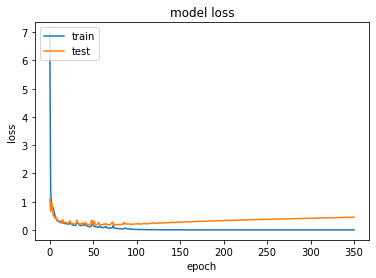

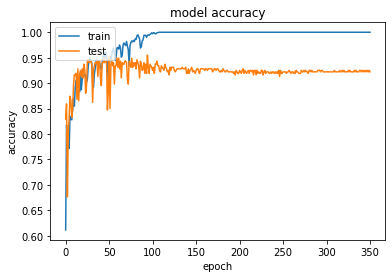

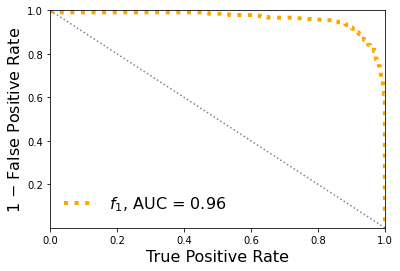

In [44]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



#######################
# Compressed Features #
#######################

input_1d_CF = Input(shape=(X_mon5_train.shape[1], 1))

dense_CF = Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(input_1d_CF)
dense_CF = keras.layers.LeakyReLU(alpha=0.05)(dense_CF)

dense_CF = Dropout(0.5)(dense_CF)
dense_CF = Flatten()(dense_CF)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top, dense_CF])


# Dense layers
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top, input_1d_CF], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [45]:
roc_auc_conv

0.9641103577273791

Classification score:


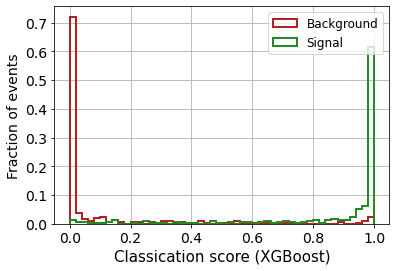

In [46]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 2 conv layer per block (final dense 64-32-16-1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 8,257,169
Trainable params: 8,257,169
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
8/8 [==============================] - 12s 1s/step - loss: 7.3736 - accuracy: 0.6266 - val_loss: 2.7880 - val_accuracy: 0.7096
Epoch 2/1500
8/8 [==============================] - 11s 1s/step - loss: 2.4027 - accuracy: 0.7497 - val_loss: 1.1866 - val_accuracy: 0.8503
Epoch 3/1500
8/8 [==============================] - 11s 1s/step - loss: 1.8414 - accuracy: 0.7678 - val_loss: 1.6635 - val_accuracy: 0.7545
Epoch 4/1500
8/8 [==============================] - 11s 1s/step - loss: 1.3926 - accuracy: 0.7698 - val_loss: 0.7749 - val_accuracy: 0.8054
Epoch 5/1500
8/8 [==============================] 

Epoch 56/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0517 - accuracy: 0.9820 - val_loss: 0.2163 - val_accuracy: 0.9251
Epoch 57/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0558 - accuracy: 0.9830 - val_loss: 0.1734 - val_accuracy: 0.9341
Epoch 58/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.2393 - val_accuracy: 0.9192
Epoch 59/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0670 - accuracy: 0.9770 - val_loss: 0.1923 - val_accuracy: 0.9371
Epoch 60/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0509 - accuracy: 0.9810 - val_loss: 0.2168 - val_accuracy: 0.9311
Epoch 61/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0482 - accuracy: 0.9870 - val_loss: 0.2026 - val_accuracy: 0.9311
Epoch 62/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0390 - accuracy: 0.9880 - val_loss: 0.1983 - val_accuracy: 0.9281
Epoch 63/1500

8/8 [==============================] - 12s 2s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3425 - val_accuracy: 0.9251
Epoch 115/1500
8/8 [==============================] - 12s 2s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3452 - val_accuracy: 0.9192
Epoch 116/1500
8/8 [==============================] - 12s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3473 - val_accuracy: 0.9222
Epoch 117/1500
8/8 [==============================] - 13s 2s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3481 - val_accuracy: 0.9222
Epoch 118/1500
8/8 [==============================] - 13s 2s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3523 - val_accuracy: 0.9192
Epoch 119/1500
8/8 [==============================] - 13s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3528 - val_accuracy: 0.9251
Epoch 120/1500
8/8 [==============================] - 13s 2s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3534 - val_accuracy: 0.9192
Epoch 121/1500
8/8 [=

8/8 [==============================] - 11s 1s/step - loss: 3.3800e-04 - accuracy: 1.0000 - val_loss: 0.4707 - val_accuracy: 0.9132
Epoch 228/1500
8/8 [==============================] - 11s 1s/step - loss: 3.3299e-04 - accuracy: 1.0000 - val_loss: 0.4703 - val_accuracy: 0.9072
Epoch 229/1500
8/8 [==============================] - 11s 1s/step - loss: 3.2459e-04 - accuracy: 1.0000 - val_loss: 0.4717 - val_accuracy: 0.9102
Epoch 230/1500
8/8 [==============================] - 11s 1s/step - loss: 3.1972e-04 - accuracy: 1.0000 - val_loss: 0.4726 - val_accuracy: 0.9132
Epoch 231/1500
8/8 [==============================] - 11s 1s/step - loss: 3.2029e-04 - accuracy: 1.0000 - val_loss: 0.4724 - val_accuracy: 0.9132
Epoch 232/1500
8/8 [==============================] - 11s 1s/step - loss: 3.1388e-04 - accuracy: 1.0000 - val_loss: 0.4742 - val_accuracy: 0.9102
Epoch 233/1500
8/8 [==============================] - 11s 1s/step - loss: 3.0446e-04 - accuracy: 1.0000 - val_loss: 0.4750 - val_accuracy: 

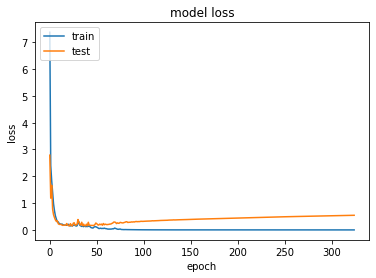

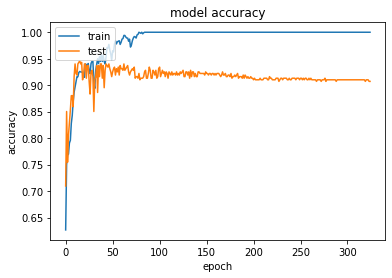

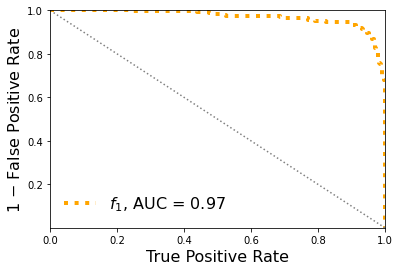

In [47]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



#######################
# Compressed Features #
#######################

input_1d_CF = Input(shape=(X_mon5_train.shape[1], 1))

dense_CF = Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(input_1d_CF)
dense_CF = keras.layers.LeakyReLU(alpha=0.05)(dense_CF)

dense_CF = Dropout(0.5)(dense_CF)
dense_CF = Flatten()(dense_CF)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top, dense_CF])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top, input_1d_CF], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [48]:
roc_auc_conv

0.9709627524684807

Classification score:


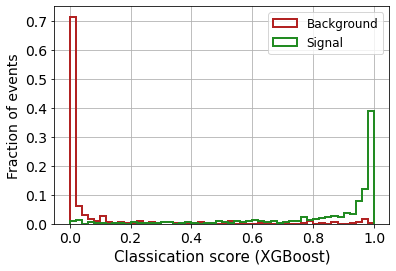

In [49]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 1 conv layer (peakS1 and Hits_bot) , 2 conv layer (peakS2 and Hits_top)  (final dense 64-32-16-1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 8,444,529
Trainable params: 8,444,529
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
8/8 [==============================] - 9s 1s/step - loss: 84.5098 - accuracy: 0.3534 - val_loss: 25.7535 - val_accuracy: 0.3054
Epoch 2/1500
8/8 [==============================] - 8s 1s/step - loss: 7.3802 - accuracy: 0.5946 - val_loss: 2.4337 - val_accuracy: 0.8743
Epoch 3/1500
8/8 [==============================] - 8s 1s/step - loss: 3.6143 - accuracy: 0.8268 - val_loss: 2.9733 - val_accuracy: 0.8443
Epoch 4/1500
8/8 [==============================] - 8s 1s/step - loss: 3.1151 - accuracy: 0.8068 - val_loss: 1.1382 - val_accuracy: 0.8802
Epoch 5/1500
8/8 [==============================] - 

8/8 [==============================] - 15s 2s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.3825 - val_accuracy: 0.9102
Epoch 114/1500
8/8 [==============================] - 15s 2s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.4967 - val_accuracy: 0.8952
Epoch 115/1500
8/8 [==============================] - 15s 2s/step - loss: 0.0181 - accuracy: 0.9970 - val_loss: 0.4055 - val_accuracy: 0.8922
Epoch 116/1500
8/8 [==============================] - 15s 2s/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.3825 - val_accuracy: 0.9192
Epoch 117/1500
8/8 [==============================] - 15s 2s/step - loss: 0.0119 - accuracy: 0.9990 - val_loss: 0.3640 - val_accuracy: 0.9192
Epoch 118/1500
8/8 [==============================] - 14s 2s/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.3712 - val_accuracy: 0.9132
Epoch 119/1500
8/8 [==============================] - 15s 2s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3625 - val_accuracy: 0.9162
Epoch 120/1500
8/8 [=

8/8 [==============================] - 15s 2s/step - loss: 3.0310e-04 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.9192
Epoch 227/1500
8/8 [==============================] - 15s 2s/step - loss: 3.0127e-04 - accuracy: 1.0000 - val_loss: 0.4927 - val_accuracy: 0.9192
Epoch 228/1500
8/8 [==============================] - 15s 2s/step - loss: 2.9394e-04 - accuracy: 1.0000 - val_loss: 0.4935 - val_accuracy: 0.9192
Epoch 229/1500
8/8 [==============================] - 15s 2s/step - loss: 2.8953e-04 - accuracy: 1.0000 - val_loss: 0.4935 - val_accuracy: 0.9192
Epoch 230/1500
8/8 [==============================] - 15s 2s/step - loss: 2.8609e-04 - accuracy: 1.0000 - val_loss: 0.4949 - val_accuracy: 0.9192
Epoch 231/1500
8/8 [==============================] - 15s 2s/step - loss: 2.8218e-04 - accuracy: 1.0000 - val_loss: 0.4965 - val_accuracy: 0.9162
Epoch 232/1500
8/8 [==============================] - 15s 2s/step - loss: 2.8219e-04 - accuracy: 1.0000 - val_loss: 0.4964 - val_accuracy: 

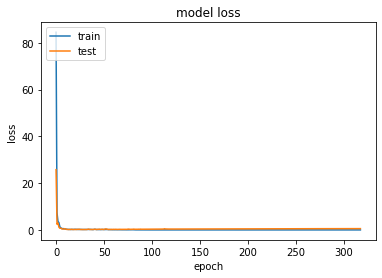

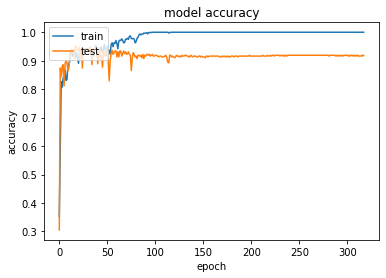

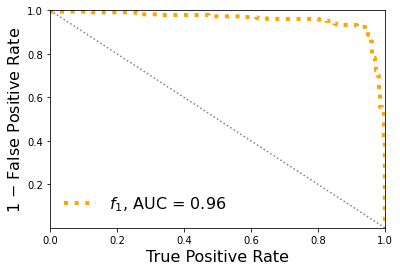

In [50]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



#######################
# Compressed Features #
#######################

input_1d_CF = Input(shape=(X_mon5_train.shape[1], 1))

dense_CF = Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(input_1d_CF)
dense_CF = keras.layers.LeakyReLU(alpha=0.05)(dense_CF)

dense_CF = Dropout(0.5)(dense_CF)
dense_CF = Flatten()(dense_CF)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top, dense_CF])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top, input_1d_CF], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [51]:
roc_auc_conv

0.958355065556375

Classification score:


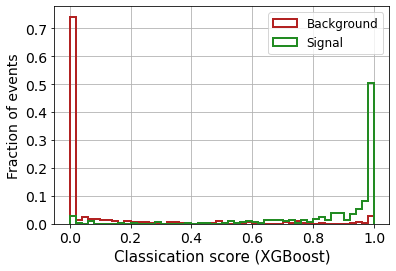

In [52]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 1 conv layer (Hits_bot and Hits_top, images) , DNN (peak S1 and peakS2, time, 64-32-16)  (final dense 64-32-16-1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 8,169,169
Trainable params: 8,169,169
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
8/8 [==============================] - 5s 506ms/step - loss: 7.8255 - accuracy: 0.6236 - val_loss: 1.8049 - val_accuracy: 0.7365
Epoch 2/1500
8/8 [==============================] - 4s 469ms/step - loss: 2.0434 - accuracy: 0.7638 - val_loss: 1.4063 - val_accuracy: 0.8084
Epoch 3/1500
8/8 [==============================] - 4s 475ms/step - loss: 1.3197 - accuracy: 0.8178 - val_loss: 0.7794 - val_accuracy: 0.8683
Epoch 4/1500
8/8 [==============================] - 4s 477ms/step - loss: 1.0575 - accuracy: 0.8108 - val_loss: 0.7467 - val_accuracy: 0.7964
Epoch 5/1500
8/8 [========================

Epoch 55/1500
8/8 [==============================] - 4s 487ms/step - loss: 0.1483 - accuracy: 0.9349 - val_loss: 0.1612 - val_accuracy: 0.9401
Epoch 56/1500
8/8 [==============================] - 4s 510ms/step - loss: 0.1055 - accuracy: 0.9570 - val_loss: 0.1521 - val_accuracy: 0.9401
Epoch 57/1500
8/8 [==============================] - 4s 520ms/step - loss: 0.0954 - accuracy: 0.9700 - val_loss: 0.1486 - val_accuracy: 0.9461
Epoch 58/1500
8/8 [==============================] - 4s 491ms/step - loss: 0.0901 - accuracy: 0.9660 - val_loss: 0.1584 - val_accuracy: 0.9371
Epoch 59/1500
8/8 [==============================] - 4s 501ms/step - loss: 0.0875 - accuracy: 0.9680 - val_loss: 0.1460 - val_accuracy: 0.9491
Epoch 60/1500
8/8 [==============================] - 4s 533ms/step - loss: 0.0882 - accuracy: 0.9730 - val_loss: 0.1503 - val_accuracy: 0.9431
Epoch 61/1500
8/8 [==============================] - 4s 538ms/step - loss: 0.0782 - accuracy: 0.9710 - val_loss: 0.1539 - val_accuracy: 0.9371

Epoch 169/1500
8/8 [==============================] - 4s 443ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2901 - val_accuracy: 0.9251
Epoch 170/1500
8/8 [==============================] - 4s 447ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2933 - val_accuracy: 0.9281
Epoch 171/1500
8/8 [==============================] - 4s 444ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2921 - val_accuracy: 0.9281
Epoch 172/1500
8/8 [==============================] - 4s 445ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2912 - val_accuracy: 0.9222
Epoch 173/1500
8/8 [==============================] - 4s 447ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3025 - val_accuracy: 0.9222
Epoch 174/1500
8/8 [==============================] - 4s 443ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9281
Epoch 175/1500
8/8 [==============================] - 4s 444ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2948 - val_accuracy:

8/8 [==============================] - 4s 449ms/step - loss: 2.8845e-04 - accuracy: 1.0000 - val_loss: 0.4035 - val_accuracy: 0.9162
Epoch 281/1500
8/8 [==============================] - 4s 451ms/step - loss: 2.8074e-04 - accuracy: 1.0000 - val_loss: 0.4071 - val_accuracy: 0.9162
Epoch 282/1500
8/8 [==============================] - 4s 447ms/step - loss: 2.7445e-04 - accuracy: 1.0000 - val_loss: 0.4073 - val_accuracy: 0.9162
Epoch 283/1500
8/8 [==============================] - 4s 445ms/step - loss: 2.7262e-04 - accuracy: 1.0000 - val_loss: 0.4078 - val_accuracy: 0.9192
Epoch 284/1500
8/8 [==============================] - 4s 444ms/step - loss: 2.7414e-04 - accuracy: 1.0000 - val_loss: 0.4106 - val_accuracy: 0.9162
Epoch 285/1500
8/8 [==============================] - 4s 443ms/step - loss: 2.7779e-04 - accuracy: 1.0000 - val_loss: 0.4111 - val_accuracy: 0.9162
Epoch 286/1500
8/8 [==============================] - 4s 448ms/step - loss: 2.7631e-04 - accuracy: 1.0000 - val_loss: 0.4119 - 

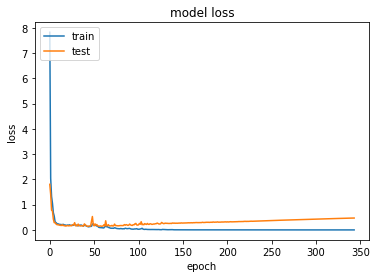

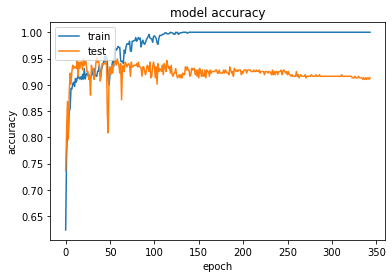

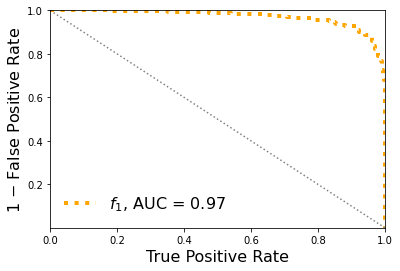

In [53]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1]))

# DNN network
conv1d_pS1 = Dense(64, activation='relu')(input_1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(32, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(16, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1]))

# Conv1D network
conv1d_pS2 = Dense(64, activation='relu')(input_1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(32, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(16, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



#######################
# Compressed Features #
#######################

input_1d_CF = Input(shape=(X_mon5_train.shape[1], 1))

dense_CF = Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(input_1d_CF)
dense_CF = keras.layers.LeakyReLU(alpha=0.05)(dense_CF)

dense_CF = Dropout(0.5)(dense_CF)
dense_CF = Flatten()(dense_CF)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top, dense_CF])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top, input_1d_CF], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [54]:
roc_auc_conv

0.9711515979928418

Classification score:


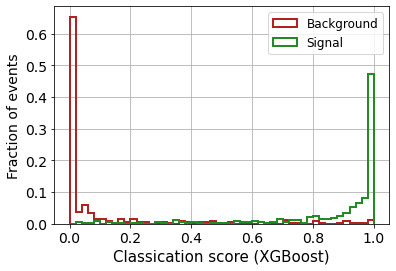

In [55]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 2 conv layer (Hits_bot and Hits_top, images) , DNN (peak S1 and peakS2, time, 64-32-16)  (final dense 64-32-16-1)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 7,794,417
Trainable params: 7,794,417
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
8/8 [==============================] - 11s 1s/step - loss: 1.6732 - accuracy: 0.6607 - val_loss: 0.4288 - val_accuracy: 0.8473
Epoch 2/1500
8/8 [==============================] - 11s 1s/step - loss: 0.4842 - accuracy: 0.7678 - val_loss: 0.4394 - val_accuracy: 0.8054
Epoch 3/1500
8/8 [==============================] - 11s 1s/step - loss: 0.4143 - accuracy: 0.7978 - val_loss: 0.3581 - val_accuracy: 0.8473
Epoch 4/1500
8/8 [==============================] - 11s 1s/step - loss: 0.3834 - accuracy: 0.8138 - val_loss: 0.3132 - val_accuracy: 0.8743
Epoch 5/1500
8/8 [==============================] 

Epoch 56/1500
8/8 [==============================] - 10s 1s/step - loss: 0.0337 - accuracy: 0.9920 - val_loss: 0.2328 - val_accuracy: 0.9192
Epoch 57/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0392 - accuracy: 0.9920 - val_loss: 0.2210 - val_accuracy: 0.9311
Epoch 58/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0309 - accuracy: 0.9940 - val_loss: 0.2318 - val_accuracy: 0.9341
Epoch 59/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0255 - accuracy: 0.9950 - val_loss: 0.2345 - val_accuracy: 0.9162
Epoch 60/1500
8/8 [==============================] - 10s 1s/step - loss: 0.0263 - accuracy: 0.9970 - val_loss: 0.2613 - val_accuracy: 0.9132
Epoch 61/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0273 - accuracy: 0.9970 - val_loss: 0.2445 - val_accuracy: 0.9341
Epoch 62/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0270 - accuracy: 0.9940 - val_loss: 0.2363 - val_accuracy: 0.9222
Epoch 63/1500

8/8 [==============================] - 10s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.4127 - val_accuracy: 0.9222
Epoch 115/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4114 - val_accuracy: 0.9132
Epoch 116/1500
8/8 [==============================] - 10s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4161 - val_accuracy: 0.9192
Epoch 117/1500
8/8 [==============================] - 10s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4185 - val_accuracy: 0.9132
Epoch 118/1500
8/8 [==============================] - 10s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4206 - val_accuracy: 0.9132
Epoch 119/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4222 - val_accuracy: 0.9162
Epoch 120/1500
8/8 [==============================] - 11s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4245 - val_accuracy: 0.9162
Epoch 121/1500
8/8 [=

Epoch 171/1500
8/8 [==============================] - 11s 1s/step - loss: 3.9072e-04 - accuracy: 1.0000 - val_loss: 0.5293 - val_accuracy: 0.9132
Epoch 172/1500
8/8 [==============================] - 11s 1s/step - loss: 3.8124e-04 - accuracy: 1.0000 - val_loss: 0.5321 - val_accuracy: 0.9132
Epoch 173/1500
8/8 [==============================] - 11s 1s/step - loss: 3.7873e-04 - accuracy: 1.0000 - val_loss: 0.5341 - val_accuracy: 0.9132
Epoch 174/1500
8/8 [==============================] - 11s 1s/step - loss: 3.7279e-04 - accuracy: 1.0000 - val_loss: 0.5358 - val_accuracy: 0.9102
Epoch 175/1500
8/8 [==============================] - 11s 1s/step - loss: 3.6887e-04 - accuracy: 1.0000 - val_loss: 0.5374 - val_accuracy: 0.9132
Epoch 176/1500
8/8 [==============================] - 11s 1s/step - loss: 3.5416e-04 - accuracy: 1.0000 - val_loss: 0.5410 - val_accuracy: 0.9102
Epoch 177/1500
8/8 [==============================] - 11s 1s/step - loss: 3.4908e-04 - accuracy: 1.0000 - val_loss: 0.5416 -

8/8 [==============================] - 11s 1s/step - loss: 6.5152e-05 - accuracy: 1.0000 - val_loss: 0.6993 - val_accuracy: 0.9012
Epoch 284/1500
8/8 [==============================] - 11s 1s/step - loss: 6.5889e-05 - accuracy: 1.0000 - val_loss: 0.7011 - val_accuracy: 0.9012
Epoch 285/1500
8/8 [==============================] - 11s 1s/step - loss: 6.6249e-05 - accuracy: 1.0000 - val_loss: 0.6999 - val_accuracy: 0.9012
Epoch 286/1500
8/8 [==============================] - 11s 1s/step - loss: 6.4536e-05 - accuracy: 1.0000 - val_loss: 0.7034 - val_accuracy: 0.9042
Epoch 287/1500
8/8 [==============================] - 11s 1s/step - loss: 6.3096e-05 - accuracy: 1.0000 - val_loss: 0.7047 - val_accuracy: 0.9012
Epoch 288/1500
8/8 [==============================] - 11s 1s/step - loss: 6.1253e-05 - accuracy: 1.0000 - val_loss: 0.7040 - val_accuracy: 0.9012
Epoch 289/1500
8/8 [==============================] - 11s 1s/step - loss: 6.1606e-05 - accuracy: 1.0000 - val_loss: 0.7074 - val_accuracy: 

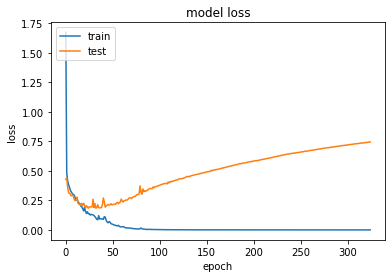

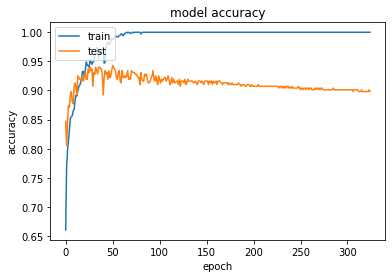

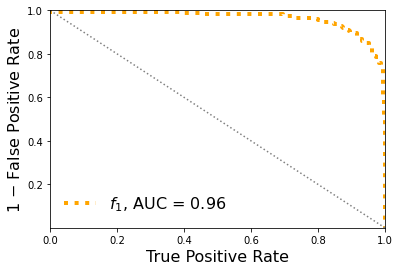

In [56]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1]))

# DNN network
conv1d_pS1 = Dense(64, activation='relu')(input_1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(32, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(16, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1]))

# Conv1D network
conv1d_pS2 = Dense(64, activation='relu')(input_1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(32, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(16, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)
conv2d_bot = Dropout(0.25)(conv2d_bot)

conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)
conv2d_top = Dropout(0.25)(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



#######################
# Compressed Features #
#######################

input_1d_CF = Input(shape=(X_mon5_train.shape[1], 1))

dense_CF = Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(input_1d_CF)
dense_CF = keras.layers.LeakyReLU(alpha=0.05)(dense_CF)

dense_CF = Dropout(0.5)(dense_CF)
dense_CF = Flatten()(dense_CF)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top, dense_CF])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top, input_1d_CF], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [57]:
roc_auc_conv

0.9647668207406341

Classification score:


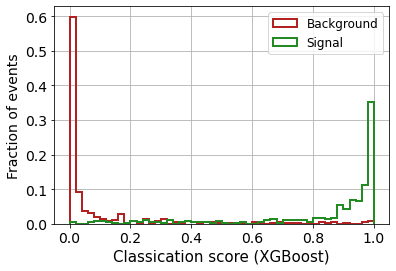

In [58]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 1 conv layer (peakS1 and Hits_bot) , 2 conv layer (peakS2 and Hits_top)  combine time in a 64-32-16 DNN, combine images in a 64-32-16 DNN (final dense 64-32-16-1)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 8,452,945
Trainable params: 8,452,945
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
8/8 [==============================] - 9s 1s/step - loss: 123.0623 - accuracy: 0.4605 - val_loss: 41.1816 - val_accuracy: 0.2395
Epoch 2/1500
8/8 [==============================] - 8s 995ms/step - loss: 25.8220 - accuracy: 0.4284 - val_loss: 19.2695 - val_accuracy: 0.5329
Epoch 3/1500
8/8 [==============================] - 8s 997ms/step - loss: 10.8213 - accuracy: 0.5576 - val_loss: 6.1683 - val_accuracy: 0.4701
Epoch 4/1500
8/8 [==============================] - 8s 992ms/step - loss: 2.6292 - accuracy: 0.6997 - val_loss: 1.4630 - val_accuracy: 0.8144
Epoch 5/1500
8/8 [=====================

Epoch 55/1500
8/8 [==============================] - 8s 991ms/step - loss: 0.0621 - accuracy: 0.9800 - val_loss: 0.2841 - val_accuracy: 0.9102
Epoch 56/1500
8/8 [==============================] - 8s 992ms/step - loss: 0.0461 - accuracy: 0.9840 - val_loss: 0.2630 - val_accuracy: 0.9192
Epoch 57/1500
8/8 [==============================] - 8s 994ms/step - loss: 0.0399 - accuracy: 0.9860 - val_loss: 0.2320 - val_accuracy: 0.9281
Epoch 58/1500
8/8 [==============================] - 8s 992ms/step - loss: 0.0288 - accuracy: 0.9900 - val_loss: 0.2757 - val_accuracy: 0.9371
Epoch 59/1500
8/8 [==============================] - 8s 998ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.2493 - val_accuracy: 0.9371
Epoch 60/1500
8/8 [==============================] - 8s 992ms/step - loss: 0.0171 - accuracy: 0.9980 - val_loss: 0.2687 - val_accuracy: 0.9431
Epoch 61/1500
8/8 [==============================] - 8s 990ms/step - loss: 0.0253 - accuracy: 0.9950 - val_loss: 0.3244 - val_accuracy: 0.9072

8/8 [==============================] - 13s 2s/step - loss: 5.1950e-04 - accuracy: 1.0000 - val_loss: 0.4545 - val_accuracy: 0.9371
Epoch 113/1500
8/8 [==============================] - 14s 2s/step - loss: 4.9976e-04 - accuracy: 1.0000 - val_loss: 0.4526 - val_accuracy: 0.9371
Epoch 114/1500
8/8 [==============================] - 12s 1s/step - loss: 4.7566e-04 - accuracy: 1.0000 - val_loss: 0.4573 - val_accuracy: 0.9371
Epoch 115/1500
8/8 [==============================] - 8s 1s/step - loss: 4.5703e-04 - accuracy: 1.0000 - val_loss: 0.4600 - val_accuracy: 0.9371
Epoch 116/1500
8/8 [==============================] - 8s 1s/step - loss: 4.4699e-04 - accuracy: 1.0000 - val_loss: 0.4657 - val_accuracy: 0.9341
Epoch 117/1500
8/8 [==============================] - 8s 1s/step - loss: 4.3026e-04 - accuracy: 1.0000 - val_loss: 0.4636 - val_accuracy: 0.9371
Epoch 118/1500
8/8 [==============================] - 8s 1s/step - loss: 4.2654e-04 - accuracy: 1.0000 - val_loss: 0.4733 - val_accuracy: 0.93

8/8 [==============================] - 8s 1s/step - loss: 2.7978e-05 - accuracy: 1.0000 - val_loss: 0.7372 - val_accuracy: 0.9132
Epoch 225/1500
8/8 [==============================] - 8s 1s/step - loss: 2.7502e-05 - accuracy: 1.0000 - val_loss: 0.7392 - val_accuracy: 0.9132
Epoch 226/1500
8/8 [==============================] - 8s 1s/step - loss: 2.7310e-05 - accuracy: 1.0000 - val_loss: 0.7383 - val_accuracy: 0.9132
Epoch 227/1500
8/8 [==============================] - 8s 1s/step - loss: 2.6367e-05 - accuracy: 1.0000 - val_loss: 0.7488 - val_accuracy: 0.9072
Epoch 228/1500
8/8 [==============================] - 8s 1s/step - loss: 2.5982e-05 - accuracy: 1.0000 - val_loss: 0.7481 - val_accuracy: 0.9132
Epoch 229/1500
8/8 [==============================] - 8s 1s/step - loss: 2.5395e-05 - accuracy: 1.0000 - val_loss: 0.7474 - val_accuracy: 0.9132
Epoch 230/1500
8/8 [==============================] - 8s 1s/step - loss: 2.5124e-05 - accuracy: 1.0000 - val_loss: 0.7505 - val_accuracy: 0.9132


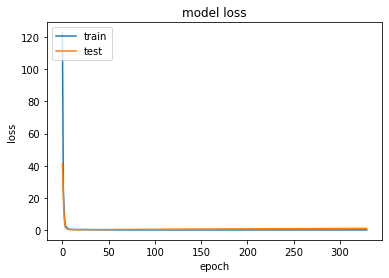

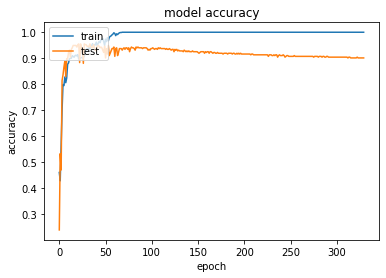

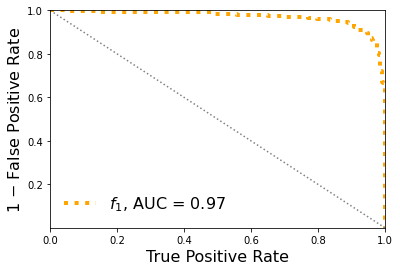

In [59]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)


# Concatenate the outputs from Conv2D and Conv1D networks
combined1 = concatenate([conv1d_pS1, conv1d_pS2])


# Dense layers
dense1 = Dense(64, activation='relu')(combined1)
dense1 = Dropout(0.20)(dense1)
dense1 = Dense(32, activation='relu')(dense1)
dense1 = Dropout(0.20)(dense1)
output1 = Dense(16, activation='relu')(dense1)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



# Concatenate the outputs from Conv2D and Conv1D networks
combined2 = concatenate([conv2d_bot, conv2d_top])


# Dense layers
dense2 = Dense(64, activation='relu')(combined2)
dense2 = Dropout(0.20)(dense2)
dense2 = Dense(32, activation='relu')(dense2)
dense2 = Dropout(0.20)(dense2)
output2 = Dense(16, activation='relu')(dense2)





#######################
# Compressed Features #
#######################

input_1d_CF = Input(shape=(X_mon5_train.shape[1], 1))

dense_CF = Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(input_1d_CF)
dense_CF = keras.layers.LeakyReLU(alpha=0.05)(dense_CF)

dense_CF = Dropout(0.5)(dense_CF)
dense_CF = Flatten()(dense_CF)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([output1, output2, dense_CF])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top, input_1d_CF], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [60]:
roc_auc_conv

0.9707469290120682

Classification score:


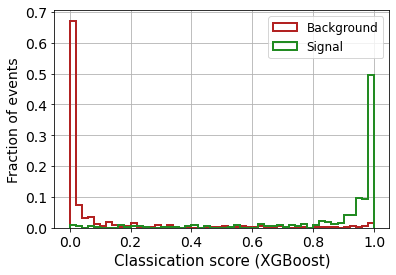

In [61]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()